In [6]:
# transfer of learning for perturbation, using the idea of threshold hebbian
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from training_abb05_threshhebb import SimpleNeuralNetwork
from tqdm import tqdm

In [7]:
# load the pickle file
with open('weights_abb05_threshhebb.pkl', 'rb') as f:
    model_rep = pickle.load(f)

In [8]:
# input and target
ndata = 200
xs = torch.linspace(0, 2 * torch.pi, ndata)
ys = torch.cos(xs)/4 + 0.5

In [9]:
# manual simulation
simu_epochs = 300
input_size = 230
theo_gain = 3 * np.ones((input_size, 1))
theo_shift = 1 * np.ones((input_size, 1))
init_gain = model_rep.gain.detach().numpy()
init_shift = model_rep.shift.detach().numpy()
init_weight = model_rep.weights.detach().numpy()
gc_thresh = np.sqrt(input_size) * 0.01
sc_thresh = np.sqrt(input_size) * 0.01
narrow_factor = 0.0001
hebbian_lr = 0.001
oja_alpha = 12

# create boundaries
has_boundary = True
gain_ub = np.maximum(init_gain, theo_gain)
gain_lb = np.minimum(init_gain, theo_gain)
shift_ub = np.maximum(init_shift, theo_shift)
shift_lb = np.minimum(init_shift, theo_shift)

# define noise
np.random.seed(42)
W = np.eye(input_size) * 0.001
x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
x_noises = torch.tensor(x_noises, dtype=torch.float32)
x_noises[:,50::] += 0.1
simu_losses = []
gain_changes = []
shift_changes = []
weight_sums = []
epoch_loss = 0

for epoch in tqdm(range(simu_epochs), position=0, leave=True):

    # shuffle data
    perm_idx = torch.randperm(ndata)
    shuffled_xs = xs[perm_idx]
    shuffled_ys = ys[perm_idx]
    last_epoch_loss = epoch_loss
    epoch_loss = 0

    for x, y in zip(shuffled_xs, shuffled_ys):
        
        # establish model
        model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

        # forward
        inpu_ipl = model.gaussian_rf(x)
        actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
        # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
        model.input_activation = actv_ipl.clone()
        inpu_opl = torch.matmul(model.weights, actv_ipl)
        actv_opl = model.activation_func(3 * (inpu_opl - 1))
        model.output_activation = actv_opl.clone()

        # backprop
        optimizer = optim.SGD([model.gain, model.shift], lr=0.2)
        loss_func = nn.MSELoss()
        output = actv_opl.squeeze()
        loss = 0.5 * loss_func(output, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # update init gains and shifts
        init_gain = model.gain.detach().numpy()
        init_shift = model.shift.detach().numpy()
        gain_change = np.linalg.norm(init_gain - theo_gain, 2)
        shift_change = np.linalg.norm(init_shift - theo_shift, 2)

        # update weights
        if loss < 0.001:
            # Calculate Hebbian weight updates
            hebbian_update = model.output_activation * (model.input_activation).T
            # Regulation term of Oja
            rj_square = (model.output_activation**2).expand(-1, model.input_size)
            oja_regulation = oja_alpha * rj_square * model.weights
            # Oja's rule
            model.weights = model.weights + hebbian_lr * hebbian_update - hebbian_lr * oja_regulation            
            # update init weights
        init_weight = model.weights.detach().numpy()

        if last_epoch_loss > 0.01 and has_boundary == True:
            has_boundary = False
            print("boundary end!!!")

        # shrink shift and gain to init value
        if last_epoch_loss < 0.001 and has_boundary == False:
            # create boundaries
            gain_ub = np.maximum(init_gain, theo_gain)
            gain_lb = np.minimum(init_gain, theo_gain)
            shift_ub = np.maximum(init_shift, theo_shift)
            shift_lb = np.minimum(init_shift, theo_shift)
            has_boundary = True
            print("boundary start!!!")
        if has_boundary and last_epoch_loss < 0.001:
            # passively narrow the boundaries
            gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
            gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
            shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
            shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
            # # actively narrow the boundaries
            # if np.linalg.norm(gain_ub - theo_gain, 2) > gc_thresh:
            #     gain_ub -= narrow_factor * (gain_ub - theo_gain)
            # if np.linalg.norm(gain_lb - theo_gain, 2) > gc_thresh:
            #     gain_lb -= narrow_factor * (gain_lb - theo_gain)
            # if np.linalg.norm(shift_ub - theo_shift, 2) > sc_thresh:
            #     shift_ub -= narrow_factor * (shift_ub - theo_shift)
            # if np.linalg.norm(shift_lb - theo_shift, 2) > sc_thresh:
            #     shift_lb -= narrow_factor * (shift_lb - theo_shift)
        # pull gains and shifts back to into boundaries
        if has_boundary:
            init_gain = np.minimum(init_gain, gain_ub)
            init_gain = np.maximum(init_gain, gain_lb)
            init_shift = np.minimum(init_shift, shift_ub)
            init_shift = np.maximum(init_shift, shift_lb)

    # print losses
    epoch_loss /= ndata
    simu_losses.append(epoch_loss)
    gain_changes.append(gain_change)
    shift_changes.append(shift_change)
    weight_sums.append(np.sum(init_weight))

    if epoch % 20 == 0:
        print(f"Epoch: {epoch}, Loss: {epoch_loss}")

  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 3/300 [00:00<00:26, 11.21it/s]

Epoch: 0, Loss: 0.0006871530889032229


  8%|▊         | 24/300 [00:01<00:12, 22.61it/s]

Epoch: 20, Loss: 0.0006752649518946541


 15%|█▌        | 45/300 [00:02<00:11, 22.37it/s]

Epoch: 40, Loss: 0.0007028521061962412


 18%|█▊        | 54/300 [00:02<00:10, 23.17it/s]

boundary end!!!


 21%|██        | 63/300 [00:02<00:09, 24.23it/s]

Epoch: 60, Loss: 0.00864279686081355


 28%|██▊       | 84/300 [00:03<00:08, 24.48it/s]

Epoch: 80, Loss: 0.003881508531254667


 35%|███▌      | 105/300 [00:04<00:08, 23.55it/s]

Epoch: 100, Loss: 0.0012755134662396017


 40%|████      | 120/300 [00:05<00:07, 23.38it/s]

boundary start!!!


 41%|████      | 123/300 [00:05<00:07, 23.23it/s]

Epoch: 120, Loss: 0.0009851740258644615


 48%|████▊     | 144/300 [00:06<00:06, 22.54it/s]

Epoch: 140, Loss: 0.0009772158380335937


 55%|█████▌    | 165/300 [00:07<00:05, 22.87it/s]

Epoch: 160, Loss: 0.001011054521714956


 61%|██████    | 183/300 [00:08<00:05, 22.73it/s]

Epoch: 180, Loss: 0.0010148483675551123


 68%|██████▊   | 204/300 [00:08<00:04, 22.61it/s]

Epoch: 200, Loss: 0.0010098593707023728


 75%|███████▌  | 225/300 [00:09<00:03, 22.37it/s]

Epoch: 220, Loss: 0.0010304148572701166


 81%|████████  | 243/300 [00:10<00:02, 22.88it/s]

Epoch: 240, Loss: 0.0011074074839433656


 88%|████████▊ | 264/300 [00:11<00:01, 23.35it/s]

Epoch: 260, Loss: 0.0010434604841553963


 95%|█████████▌| 285/300 [00:12<00:00, 23.11it/s]

Epoch: 280, Loss: 0.0010355195692661212


100%|██████████| 300/300 [00:13<00:00, 22.79it/s]


In [10]:
# # manual simulation 2
# # The idea of in-turn stage of bp, hebb, narrow does not work; would stuck in bp
# simu_epochs = 500
# input_size = 230
# theo_gain = 3 * np.ones((input_size, 1))
# theo_shift = 1 * np.ones((input_size, 1))
# init_gain = model_rep.gain.detach().numpy()
# init_shift = model_rep.shift.detach().numpy()
# init_weight = model_rep.weights.detach().numpy()
# gc_thresh = np.sqrt(input_size) * 0.01
# sc_thresh = np.sqrt(input_size) * 0.01
# narrow_factor = 0.001
# hebbian_lr = 0.001
# oja_alpha = 12

# # create boundaries
# has_boundary = True
# gain_ub = np.maximum(init_gain, theo_gain)
# gain_lb = np.minimum(init_gain, theo_gain)
# shift_ub = np.maximum(init_shift, theo_shift)
# shift_lb = np.minimum(init_shift, theo_shift)

# # define noise
# np.random.seed(42)
# W = np.eye(input_size) * 0.001
# x_noises = (np.random.multivariate_normal(mean=np.zeros(input_size), cov=W, size=simu_epochs)).T * 0
# x_noises = torch.tensor(x_noises, dtype=torch.float32)
# x_noises[:,50::] += 0.1
# simu_losses = []
# gain_changes = []
# shift_changes = []
# weight_sums = []
# epoch_loss = 0
# stage = 'backprop'

# for epoch in tqdm(range(simu_epochs), position=0, leave=True):

#     # shuffle data
#     perm_idx = torch.randperm(ndata)
#     shuffled_xs = xs[perm_idx]
#     shuffled_ys = ys[perm_idx]
#     last_epoch_loss = epoch_loss
#     epoch_loss = 0

#     # forced backprop when loss too large
#     if last_epoch_loss > 0.01 and stage != 'backprop':
#         stage = 'backprop'
#         print("forced backprop!!!")
#     # forced abandon boundary when loss too large
#     if last_epoch_loss > 0.01 and has_boundary == True:
#         has_boundary = False
#         print("boundary end!!!")
#     # start boundary when loss is small
#     if last_epoch_loss < 0.001 and has_boundary == False:
#         gain_ub = np.maximum(init_gain, theo_gain)
#         gain_lb = np.minimum(init_gain, theo_gain)
#         shift_ub = np.maximum(init_shift, theo_shift)
#         shift_lb = np.minimum(init_shift, theo_shift)
#         has_boundary = True
#         print("boundary start!!!")
#     # start hebbian when loss is small
#     if last_epoch_loss < 0.001 and stage == 'backprop':
#         stage = 'hebbian'
#         print("hebbian start!!!")
#     # narrow boundary and start backprop when hebbian convergence
#     elif len(simu_losses) >= 5 and np.std(simu_losses[-5:]) < 0.001 and stage == 'hebbian':
#         # passively narrow the boundaries
#         gain_ub = np.maximum(np.minimum(init_gain, gain_ub), theo_gain)
#         gain_lb = np.minimum(np.maximum(init_gain, gain_lb), theo_gain)
#         shift_ub = np.maximum(np.minimum(init_shift, shift_ub), theo_shift)
#         shift_lb = np.minimum(np.maximum(init_shift, shift_lb), theo_shift)
#         # actively narrow the boundaries
#         if np.linalg.norm(gain_ub - theo_gain, 2) > gc_thresh:
#             gain_ub -= narrow_factor * (gain_ub - theo_gain)
#         if np.linalg.norm(gain_lb - theo_gain, 2) > gc_thresh:
#             gain_lb -= narrow_factor * (gain_lb - theo_gain)
#         if np.linalg.norm(shift_ub - theo_shift, 2) > sc_thresh:
#             shift_ub -= narrow_factor * (shift_ub - theo_shift)
#         if np.linalg.norm(shift_lb - theo_shift, 2) > sc_thresh:
#             shift_lb -= narrow_factor * (shift_lb - theo_shift)
#         # pull back into boundary
#         init_gain = np.minimum(init_gain, gain_ub)
#         init_gain = np.maximum(init_gain, gain_lb)
#         init_shift = np.minimum(init_shift, shift_ub)
#         init_shift = np.maximum(init_shift, shift_lb)
#         stage = 'backprop'
#         print("converge!! start backprop!!!")

#     for x, y in zip(shuffled_xs, shuffled_ys):
        
#         # establish model
#         model = SimpleNeuralNetwork(input_size, init_gain, init_shift, init_weight)

#         # forward
#         inpu_ipl = model.gaussian_rf(x)
#         actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift)) + (x_noises[:, epoch]).reshape(-1, 1)
#         # actv_ipl = model.activation_func(model.gain * (inpu_ipl - model.shift))
#         model.input_activation = actv_ipl.clone()
#         inpu_opl = torch.matmul(model.weights, actv_ipl)
#         actv_opl = model.activation_func(3 * (inpu_opl - 1))
#         model.output_activation = actv_opl.clone()

#         # loss
#         output = actv_opl.squeeze()
#         loss = 0.5 * loss_func(output, y)
#         epoch_loss += loss.item()

#         # backprop
#         if stage == 'backprop':
#             optimizer = optim.SGD([model.gain, model.shift], lr=0.2)
#             loss_func = nn.MSELoss()
#             loss.backward()
#             optimizer.step()

#         # update init gains and shifts
#         init_gain = model.gain.detach().numpy()
#         init_shift = model.shift.detach().numpy()
#         gain_change = np.linalg.norm(init_gain - theo_gain, 2)
#         shift_change = np.linalg.norm(init_shift - theo_shift, 2)
        
#         # pull into boundary
#         if has_boundary:
#             init_gain = np.minimum(init_gain, gain_ub)
#             init_gain = np.maximum(init_gain, gain_lb)
#             init_shift = np.minimum(init_shift, shift_ub)
#             init_shift = np.maximum(init_shift, shift_lb)

#         # update weights
#         if stage == 'hebbian':
#             # Calculate Hebbian weight updates
#             hebbian_update = model.output_activation * (model.input_activation).T
#             # Regulation term of Oja
#             rj_square = (model.output_activation**2).expand(-1, model.input_size)
#             oja_regulation = oja_alpha * rj_square * model.weights
#             # Oja's rule
#             model.weights = model.weights + hebbian_lr * hebbian_update - hebbian_lr * oja_regulation            
#             # update init weights
#         init_weight = model.weights.detach().numpy()
        
#     # print losses
#     epoch_loss /= ndata
#     simu_losses.append(epoch_loss)
#     gain_changes.append(gain_change)
#     shift_changes.append(shift_change)
#     weight_sums.append(np.sum(init_weight))

#     if epoch % 20 == 0:
#         print(f"Epoch: {epoch}, Loss: {epoch_loss}")

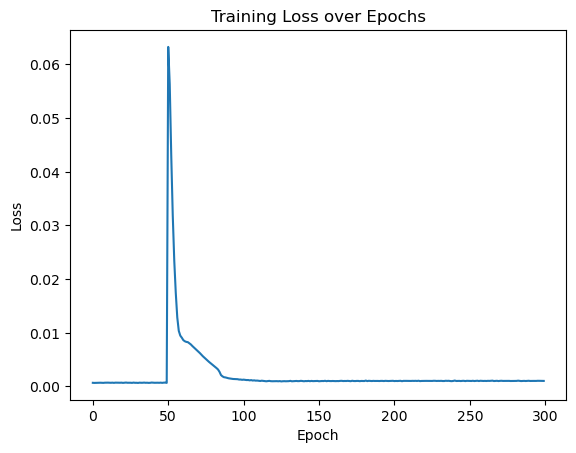

In [11]:
# Plotting the loss
plt.plot(range(simu_epochs), simu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,0.01])
plt.title('Training Loss over Epochs')
# plt.savefig('abb05_loss.png')
plt.show()

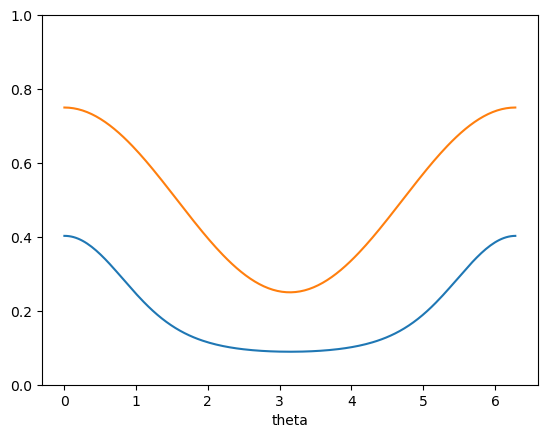

In [12]:
# Plotting the outputs
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs)
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
# plt.savefig('abb05_outputs.png')
plt.show()

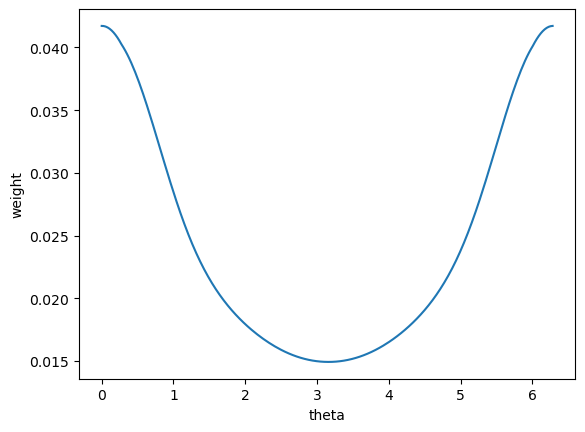

In [13]:
final_weight = model.weights.detach().numpy()
plt.plot(np.linspace(0, 2 * np.pi, model.input_size), final_weight.flatten())
# plt.ylim([0,8])
plt.xlabel("theta")
plt.ylabel("weight")
# plt.savefig('abb05_ws.png')
plt.show()

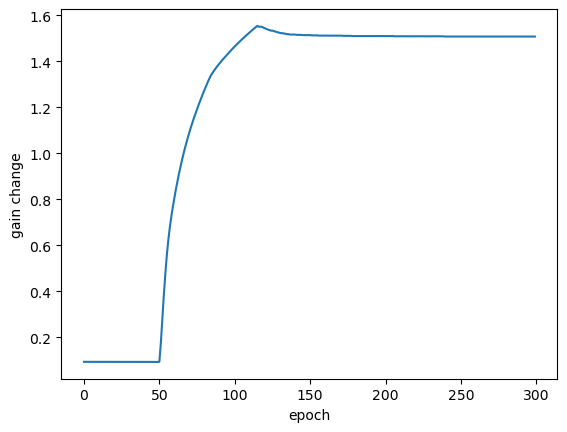

In [14]:
plt.plot(np.arange(simu_epochs), gain_changes)
plt.xlabel("epoch")
plt.ylabel("gain change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_gc.png')
plt.show()

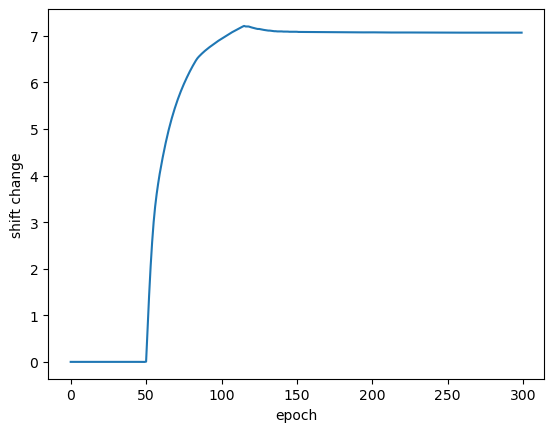

In [15]:
plt.plot(np.arange(simu_epochs), shift_changes)
plt.xlabel("epoch")
plt.ylabel("shift change")
# plt.hlines(y=np.sqrt(460)*0.1, xmin=0, xmax=epochs)
# plt.savefig('abb05_sc.png')
plt.show()

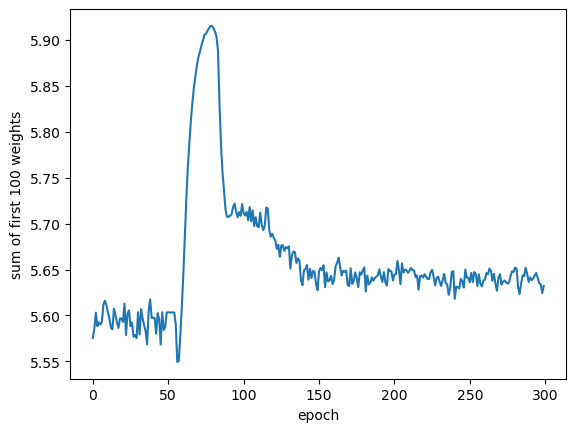

In [16]:
plt.plot(np.arange(simu_epochs), weight_sums)
# plt.ylim([0,8])
plt.xlabel("epoch")
plt.ylabel("sum of first 100 weights")
# plt.savefig('abb05_ws.png')
plt.show()

In [17]:
rates = []
for x in xs:
    input = model.gaussian_rf(x)
    rate = model.activation_func(model.gain * (input - model.shift))
    rates.append(rate)
rates = torch.cat(rates, dim=1)
rates = rates.detach().numpy().round(4)
rates

array([[0.4153, 0.415 , 0.4138, ..., 0.4138, 0.415 , 0.4153],
       [0.4149, 0.4151, 0.4147, ..., 0.412 , 0.4138, 0.4149],
       [0.4134, 0.4144, 0.4146, ..., 0.4093, 0.4118, 0.4134],
       ...,
       [0.4137, 0.412 , 0.4096, ..., 0.4148, 0.4146, 0.4137],
       [0.415 , 0.4139, 0.4122, ..., 0.4148, 0.4152, 0.415 ],
       [0.4153, 0.415 , 0.4138, ..., 0.4138, 0.415 , 0.4153]],
      dtype=float32)

Text(0, 0.5, 'firing rate')

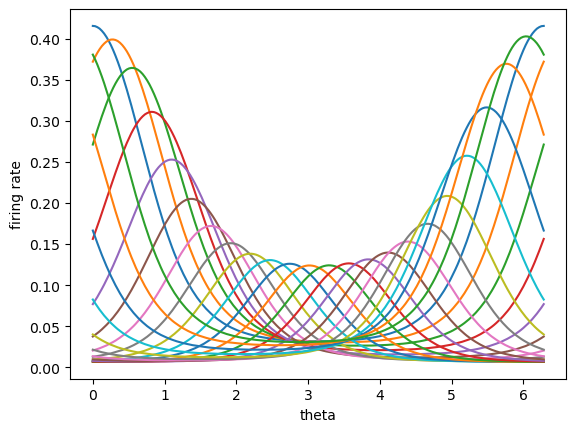

In [18]:
for i in np.arange(0,model.input_size,10):
    thisr = rates[i,:]
    plt.plot(xs, thisr)
plt.xlabel("theta")
plt.ylabel("firing rate")
# plt.savefig('abb05_rf.png')

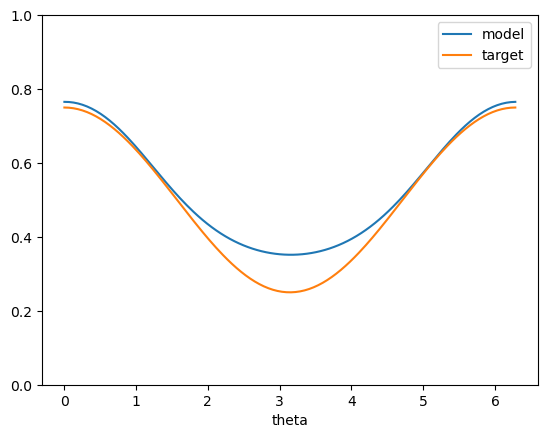

In [19]:
# Plotting the outputs
model.gain = model.init_gain
model.shift = model.init_shift
model.eval()
outputs = []
for x in xs:
    output = model(x)
    outputs.append(output.item())
plt.plot(xs, outputs, label='model')
plt.plot(xs, ys, label='target')
plt.ylim([0,1])
plt.xlabel("theta")
plt.legend()
# plt.savefig('abb05_outputs_nosup.png')